In [1]:
#Changer le répertoire courant pour l'import des modules
import os

current_dir = os.getcwd()

target_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))

os.chdir(target_dir)

In [2]:
from loadData import ThoraxDataLoader
import SimpleITK 
import skimage.io as io

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torch.nn.functional as F

from matplotlib import cm
from matplotlib.colors import ListedColormap

In [3]:
loader = ThoraxDataLoader("./Data/Data_Medical/MCsimulations")
LS_dataset = loader.load_all_samples("LS")
CT_dataset = loader.load_all_samples("CT")
y_dataset = np.load("Segmentation/segmentation.npy")
newcmp = loader.newcmp

sample_0001 chargé avec succès.
sample_0002 chargé avec succès.
sample_0003 chargé avec succès.
sample_0004 chargé avec succès.
sample_0005 chargé avec succès.
sample_0006 chargé avec succès.
sample_0007 chargé avec succès.
sample_0008 chargé avec succès.
sample_0009 chargé avec succès.
sample_0010 chargé avec succès.
sample_0011 chargé avec succès.
sample_0012 chargé avec succès.
sample_0013 chargé avec succès.
sample_0014 chargé avec succès.
sample_0015 chargé avec succès.
sample_0016 chargé avec succès.
sample_0017 chargé avec succès.
sample_0018 chargé avec succès.
sample_0019 chargé avec succès.
sample_0020 chargé avec succès.
sample_0021 chargé avec succès.
sample_0022 chargé avec succès.
sample_0023 chargé avec succès.
sample_0024 chargé avec succès.
sample_0025 chargé avec succès.
sample_0026 chargé avec succès.
sample_0027 chargé avec succès.
sample_0028 chargé avec succès.
sample_0029 chargé avec succès.
sample_0030 chargé avec succès.
sample_0031 chargé avec succès.
sample_0

In [4]:
LS_dataset.shape, CT_dataset.shape, y_dataset.shape

((6560, 64, 64), (6560, 64, 64), (6560, 64, 64))

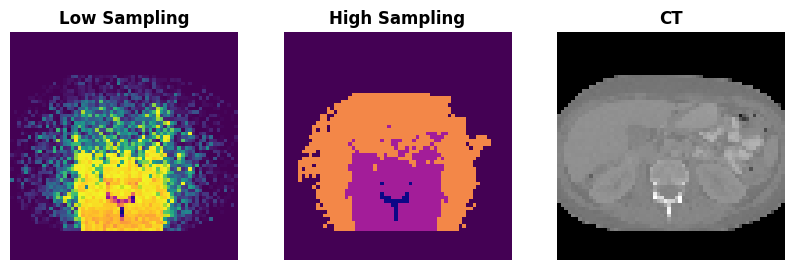

In [ ]:
train_lenght = int(0.70*len(LS_dataset))
val_lenght = int(0.80*len(LS_dataset))

LS = LS_dataset[val_lenght,:,:]
CT = CT_dataset[val_lenght,:,:]
HS = y_dataset[val_lenght,:,:]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(LS, interpolation=None, cmap=newcmp)
axes[0].set_title('Low Sampling', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(HS, interpolation=None, cmap='viridis')
axes[1].set_title('GMM Segmentation', fontweight='bold')
axes[1].axis('off')

axes[2].imshow(CT, interpolation=None, cmap='gray')
axes[2].set_title('CT', fontweight='bold')
axes[2].axis('off')

plt.show()

# UNet Model with PyTorch

In [97]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(2, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        # Output
        self.output_conv = nn.Conv2d(64, 4, kernel_size=1, padding=0)    
    
    def conv_block(self, in_channels, out_channels):
        """Bloc de convolution : Conv2D -> ReLU -> Conv2D -> ReLU."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        
        c2 = self.enc2(p1)
        p2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        
        c3 = self.enc3(p2)
        p3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        
        c4 = self.enc4(p3)
        p4 = F.max_pool2d(c4, kernel_size=2, stride=2)
        
        # Bottleneck
        bn = self.bottleneck(p4)
        
        # Decoder
        u4 = self.upconv4(bn)
        u4 = torch.cat((u4, c4), dim=1)  # Skip connection
        c5 = self.dec4(u4)
        
        u3 = self.upconv3(c5)
        u3 = torch.cat((u3, c3), dim=1)  # Skip connection
        c6 = self.dec3(u3)
        
        u2 = self.upconv2(c6)
        u2 = torch.cat((u2, c2), dim=1)  # Skip connection
        c7 = self.dec2(u2)
        
        u1 = self.upconv1(c7)
        u1 = torch.cat((u1, c1), dim=1)  # Skip connection
        c8 = self.dec1(u1)
        
        # Output
        outputs = self.output_conv(c8)

        return outputs

In [98]:
train_lenght = int(0.70*len(LS_dataset))
val_lenght = int(0.80*len(LS_dataset))

LS_train = torch.tensor(LS_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)
CT_train = torch.tensor(CT_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)
x_train = torch.cat((LS_train, CT_train), dim=1)
y_train = torch.tensor(y_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)

LS_val = torch.tensor(LS_dataset[train_lenght:val_lenght,:,:], dtype=torch.float32).unsqueeze(1)
CT_val = torch.tensor(CT_dataset[train_lenght:val_lenght,:,:], dtype=torch.float32).unsqueeze(1)
x_val = torch.cat((LS_val, CT_val), dim=1)
y_val = torch.tensor(y_dataset[train_lenght:val_lenght,:,:],  dtype=torch.float32).unsqueeze(1)

LS_test = torch.tensor(LS_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)
CT_test = torch.tensor(CT_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)
x_test = torch.cat((LS_test, CT_test), dim=1)
y_test = torch.tensor(y_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

(torch.Size([4592, 2, 64, 64]),
 torch.Size([4592, 1, 64, 64]),
 torch.Size([656, 2, 64, 64]),
 torch.Size([656, 1, 64, 64]),
 torch.Size([1312, 2, 64, 64]),
 torch.Size([1312, 1, 64, 64]))

In [99]:
batch_size = 10

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [102]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Met le modèle en mode évaluation
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Désactive le calcul des gradients
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.squeeze(1).to(torch.long).to(device)

            # Passage avant
            outputs = model(inputs)

            # Calcul de la perte
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calcul de la précision
            _, predicted = torch.max(outputs, 1)  # Prédictions de classe
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calcul de la perte moyenne et de la précision
    val_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    print("Validation Set Loss : ", val_loss)
    return val_loss, accuracy


In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5

best_model_wts = model.state_dict()  # Initialisation de l'état du meilleur modèle
best_loss = float('inf')  # Initialisation de la meilleure perte

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (inputs, targets) in enumerate(train_loader):
        
        inputs, targets = inputs.to(device), targets.squeeze(1).to(torch.long).to(device)  # Déplacer vers GPU si disponible

        # Initialiser les gradients
        optimizer.zero_grad()

        # Passer les données dans le modèle
        outputs = model(inputs)

        # Calculer la perte
        loss = criterion(outputs, targets)

        # Rétropropagation
        loss.backward()

        # Mise à jour des poids
        optimizer.step()

        # Accumuler la perte
        running_loss += loss.item()

        # Afficher la perte
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss:.4f}")
    
    # Évaluation sur le jeu de validation
    val_loss = evaluate_model(model, val_loader, criterion, device)[0]

    if val_loss < best_loss:  # Si la perte sur la validation est meilleure
        best_loss = val_loss
        best_model_wts = model.state_dict()  # Sauvegarder l'état actuel du modèle

torch.save(best_model_wts, "best_segm_model")
print("Entraînement terminé")

Epoch [1/5], Batch [1/460], Loss: 1.3812
Epoch [1/5], Batch [2/460], Loss: 1.3822
Epoch [1/5], Batch [3/460], Loss: 1.3739
Epoch [1/5], Batch [4/460], Loss: 1.3743
Epoch [1/5], Batch [5/460], Loss: 1.3735
Epoch [1/5], Batch [6/460], Loss: 1.3723
Epoch [1/5], Batch [7/460], Loss: 1.3670
Epoch [1/5], Batch [8/460], Loss: 1.3668
Epoch [1/5], Batch [9/460], Loss: 1.3657
Epoch [1/5], Batch [10/460], Loss: 1.3595
Epoch [1/5], Batch [11/460], Loss: 1.3612
Epoch [1/5], Batch [12/460], Loss: 1.3599
Epoch [1/5], Batch [13/460], Loss: 1.3541
Epoch [1/5], Batch [14/460], Loss: 1.3540
Epoch [1/5], Batch [15/460], Loss: 1.3501
Epoch [1/5], Batch [16/460], Loss: 1.3471
Epoch [1/5], Batch [17/460], Loss: 1.3367
Epoch [1/5], Batch [18/460], Loss: 1.3336
Epoch [1/5], Batch [19/460], Loss: 1.3319
Epoch [1/5], Batch [20/460], Loss: 1.3134
Epoch [1/5], Batch [21/460], Loss: 1.3129
Epoch [1/5], Batch [22/460], Loss: 1.2870
Epoch [1/5], Batch [23/460], Loss: 1.2789
Epoch [1/5], Batch [24/460], Loss: 1.2603
E

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Déplacez le modèle sur l'appareil approprié
model = model.to(device)

# Déplacez les données d'entrée sur le même appareil que le modèle
x_test = x_test.to(device)

# Effectuez la prédiction
model.eval()
with torch.no_grad():
    y_pred = model(x_test).cpu()  # Revenir sur CPU si nécessaire pour l'évaluation
    y_pred = torch.argmax(y_pred, dim=1)

y_pred2 = y_pred.cpu().squeeze(1).numpy()
y_test2 = y_test.cpu().squeeze(1).numpy()


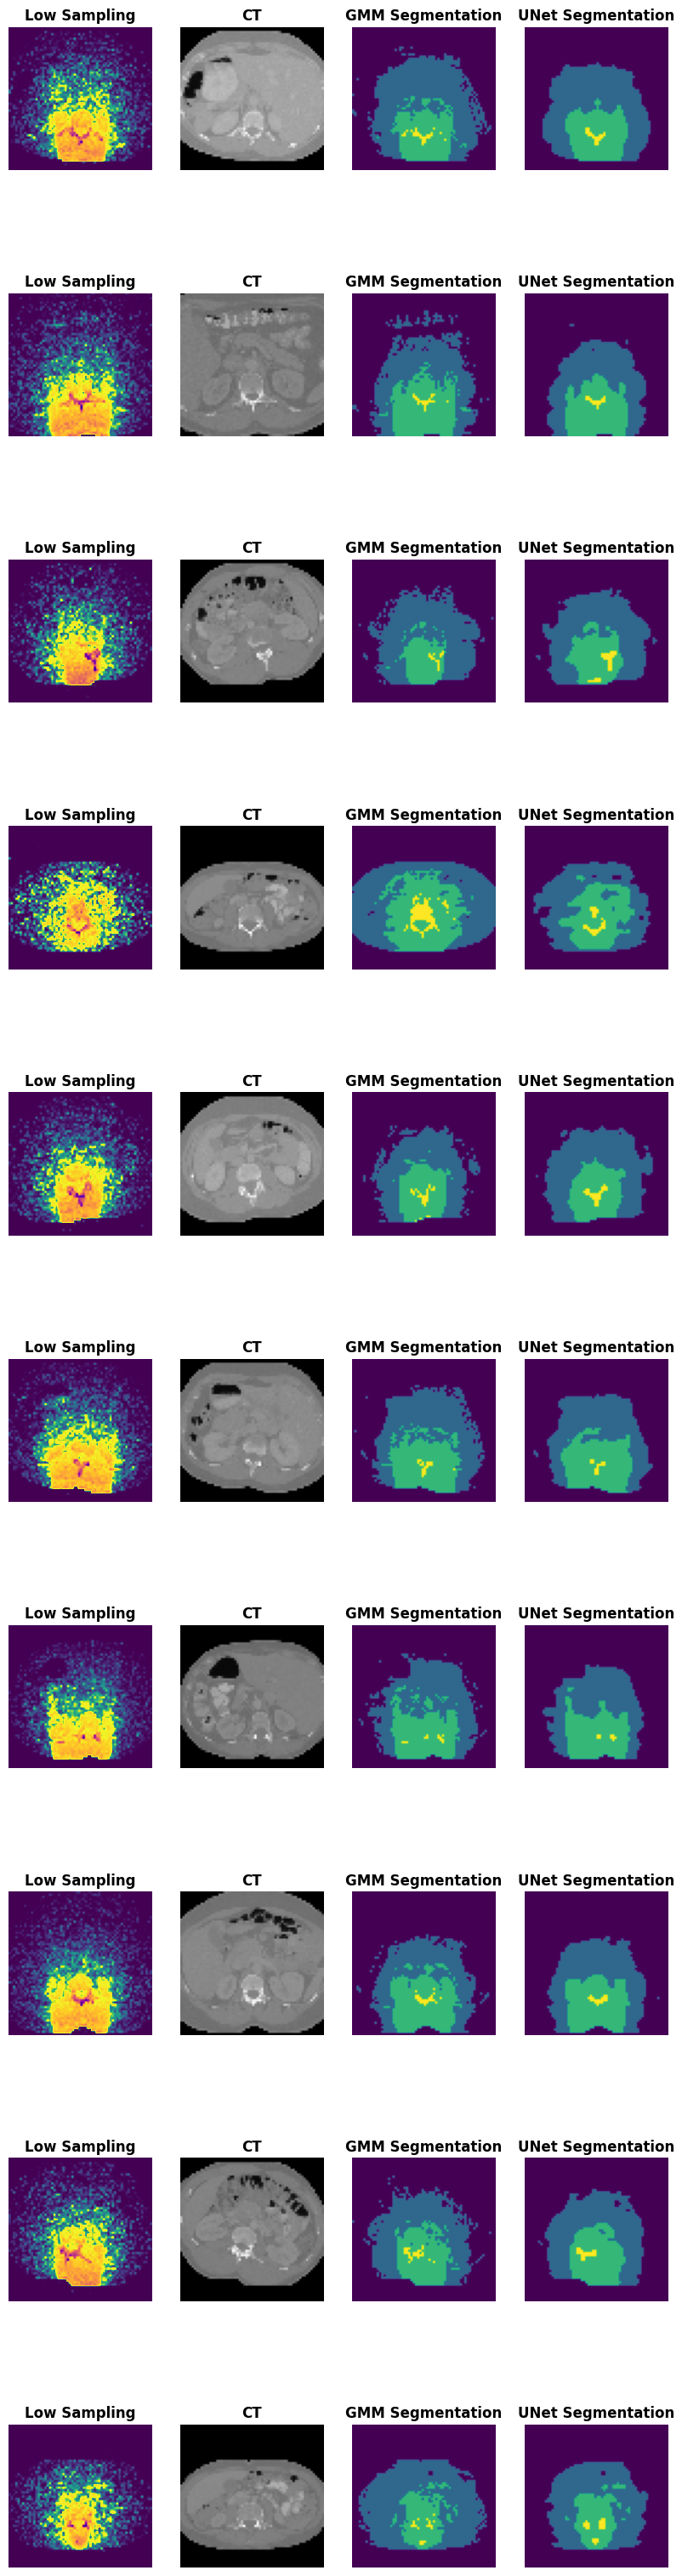

In [110]:
fig, axes = plt.subplots(10, 4, figsize=(10, 10 * 4))

for i in range(10):

    rd_int = np.random.randint(0, len(y_pred))

    axes[i, 0].imshow(x_test[rd_int, 0].cpu().numpy(), cmap=newcmp)
    axes[i, 0].set_title('Low Sampling', fontweight='bold')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(x_test[rd_int, 1].cpu().numpy(), cmap='gray')
    axes[i, 1].set_title('CT', fontweight='bold')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(y_test2[rd_int], cmap='viridis')
    axes[i, 2].set_title('GMM Segmentation', fontweight='bold')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(y_pred[rd_int], cmap='viridis')
    axes[i, 3].set_title('UNet Segmentation', fontweight='bold')
    axes[i, 3].axis('off')

plt.show()